In [12]:
import pickle
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split

from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from yellowbrick.regressor import ResidualsPlot
import shap

In [13]:
T1 = pd.read_csv("../data/T1_r.csv")
T2 = pd.read_csv("../data/T2_r.csv")
T2star = pd.read_csv("../data/T2star_r.csv")
ASL = pd.read_csv("../data/ASL_r.csv")
DWI = pd.read_csv("../data/DWI_r.csv")
meta_names = ["seqtype", "experiment", "minutes", "vivo_status", "positioning", "ischemia", "kidney_code"]

total = pd.concat([
    # T1, 
    T2, 
    # T2star, 
    # ASL, 
    # DWI
    ])

meta = total["Image"].apply(lambda x: x.split("/")[-1].strip(".nrrd")).str.split("_", expand=True)
numeric_cols_mask_pd = total.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x)).values
total_numeric = total.loc[:, numeric_cols_mask_pd]

meta = total["Image"].apply(lambda x: x.split("/")[-1].strip(".nrrd")).str.split("_", expand=True)
meta.columns = meta_names
meta.experiment = meta.experiment.astype(int)
meta.minutes = meta.minutes.astype(int)

In [14]:
wi = (meta.ischemia == "wi")

meta = meta[wi]
total_numeric = total_numeric[wi]

In [572]:
optimal_params = {'xgbregressor__colsample_bytree': 0.91, 
                  'xgbregressor__learning_rate': 0.01, 
                  'xgbregressor__max_depth': 2, 
                  'xgbregressor__n_estimators': 1000, 
                  'xgbregressor__subsample': 0.6}

In [573]:
top_20_features = ['original_gldm_DependenceEntropy', 'original_firstorder_Kurtosis', 
                   'original_shape_Maximum2DDiameterRow', 'original_shape_Maximum2DDiameterSlice', 
                   'original_gldm_DependenceVariance', 'original_shape_MajorAxisLength', 
                   'original_glszm_LargeAreaEmphasis', 'original_glszm_ZoneVariance', 
                   'diagnostics_Image-original_Maximum', 'original_shape_LeastAxisLength', 
                   'original_gldm_DependenceNonUniformityNormalized', 'diagnostics_Image-original_Mean', 
                   'original_shape_Maximum3DDiameter', 'original_firstorder_Skewness', 
                   'original_glszm_SizeZoneNonUniformity', 'original_glszm_LargeAreaHighGrayLevelEmphasis', 
                   'original_firstorder_10Percentile', 'original_gldm_DependenceNonUniformity', 
                   'original_shape_Flatness', 'original_firstorder_Energy']

In [15]:
y = meta["minutes"]

In [16]:
xstrain, xstest, ystrain, ystest = train_test_split(total_numeric, y, test_size=.2)

xgbr = XGBRegressor(colsample_bytree=0.91, 
                    learning_rate=0.015, 
                    max_depth=2, 
                    n_estimators=1000, 
                    subsample=0.6)
xgbr.fit(xstrain, ystrain)
xgbr.score(xstest, ystest)

0.39585554599761963

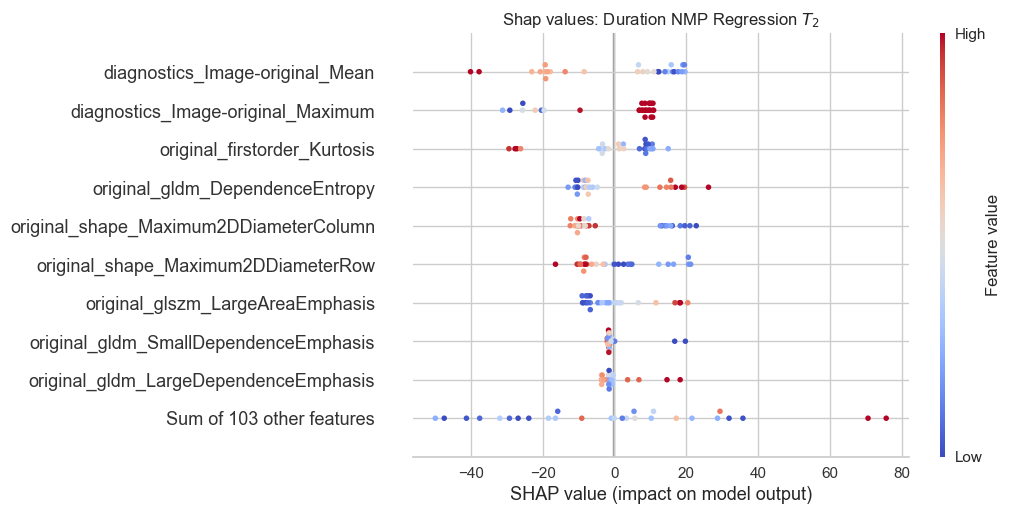

In [27]:
explainer = shap.Explainer(xgbr, xstest)
shap_values = explainer(xstest)
plt.title(r"Shap values: Duration NMP Regression $T_2$")
shap.plots.beeswarm(shap_values, max_display=10, order=shap_values.abs.max(0), color=plt.get_cmap("coolwarm"))
plt.show()

In [577]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(xgbr, total_numeric, y, cv=10, scoring='r2')

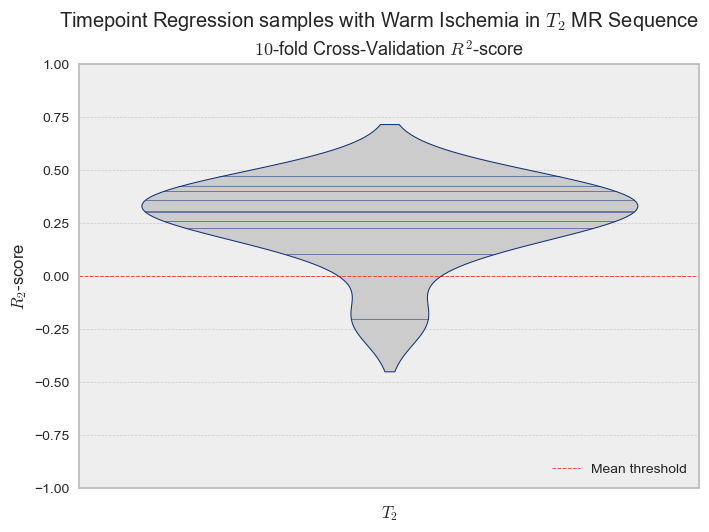

In [589]:
plt.style.use('bmh')
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7 ,linewidth=0.7, label=r'Mean threshold')
sns.violinplot(scores, color=".8", linecolor="#137", linewidth=.75, fill=True, inner="stick")
plt.ylim((-1, 1))
plt.suptitle(r"Timepoint Regression samples with Warm Ischemia in $T_2$ MR Sequence")
plt.title(r"$10$-fold Cross-Validation $R^2$-score", fontsize=13)
plt.xlabel(r"$T_2$", fontsize=12)
plt.ylabel(r"$R_2$-score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(loc="lower right")
plt.show()

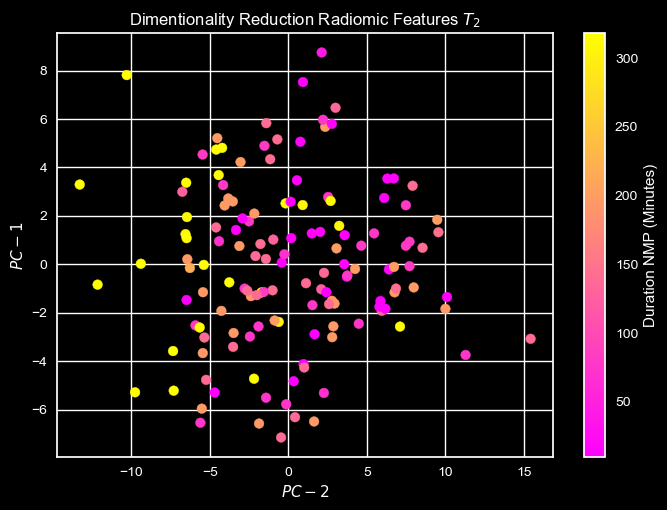

In [8]:
sc = StandardScaler()
pca = PCA(n_components=2)
pcs = pca.fit_transform(sc.fit_transform(total_numeric))
with plt.style.context("dark_background"):
    plt.scatter(pcs[:,0], pcs[:,1], c=y, cmap="spring")
    plt.title(r"Dimentionality Reduction Radiomic Features $T_2$")
    plt.xlabel(r"$PC-2$")
    plt.ylabel(r"$PC-1$")
    cbar = plt.colorbar() # Capture the colorbar instance
    cbar.set_label('Duration NMP (Minutes)') # Set the label for the colorbar
plt.show()

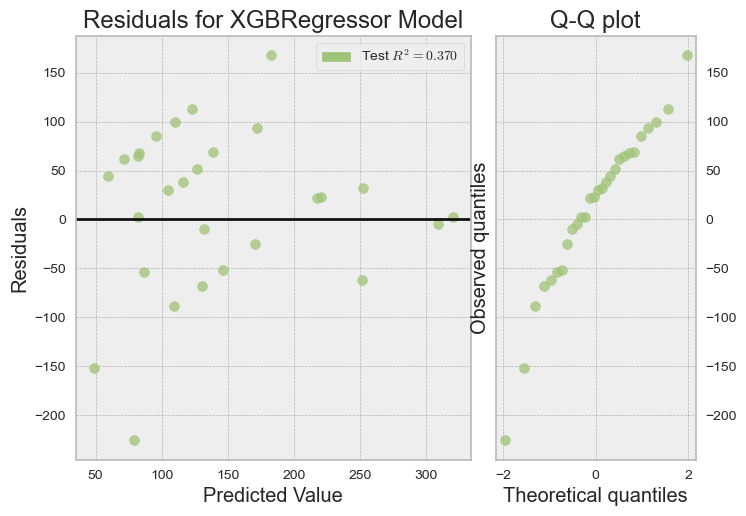

In [579]:
visualizer = ResidualsPlot(xgbr, hist=False, qqplot=True)
visualizer.score(xstest, ystest)
visualizer.show()
plt.show()

In [580]:
mean_abs_shap_values = np.abs(shap_values.values).mean(0)
feature_importance = pd.Series(mean_abs_shap_values, index=xstrain.columns)
top_features = feature_importance.sort_values(ascending=False)
top_20_feature_names = top_features.index[:20].tolist()

print("Top 20 feature names:")
print(top_20_feature_names)

Top 20 feature names:
['diagnostics_Image-original_Mean', 'original_gldm_DependenceEntropy', 'original_glszm_LargeAreaEmphasis', 'original_shape_Maximum2DDiameterRow', 'original_glszm_SizeZoneNonUniformity', 'original_firstorder_10Percentile', 'original_firstorder_Skewness', 'original_glszm_ZoneEntropy', 'diagnostics_Image-original_Maximum', 'original_firstorder_Mean', 'original_firstorder_Kurtosis', 'original_glszm_ZoneVariance', 'original_glszm_SmallAreaEmphasis', 'original_shape_Flatness', 'diagnostics_Mask-original_VolumeNum', 'original_shape_Maximum2DDiameterColumn', 'original_gldm_LargeDependenceEmphasis', 'original_gldm_SmallDependenceEmphasis', 'original_shape_Maximum2DDiameterSlice', 'original_gldm_DependenceNonUniformity']


In [581]:
top_shap = total_numeric[top_20_features]
xstrain, xstest, ystrain, ystest = train_test_split(top_shap, y, test_size=.2)

xgbr_top = XGBRegressor(colsample_bytree=0.91, 
                    learning_rate=0.015, 
                    max_depth=2, 
                    n_estimators=1000, 
                    subsample=0.6)
xgbr_top.fit(xstrain, ystrain)
xgbr_top.score(xstest, ystest)

0.4588555693626404

In [582]:
# with open("../models/top20_features_r2_62_WI_T2.pkl", "b+w") as pout:
#     pickle.dump(xgbr_top, pout)

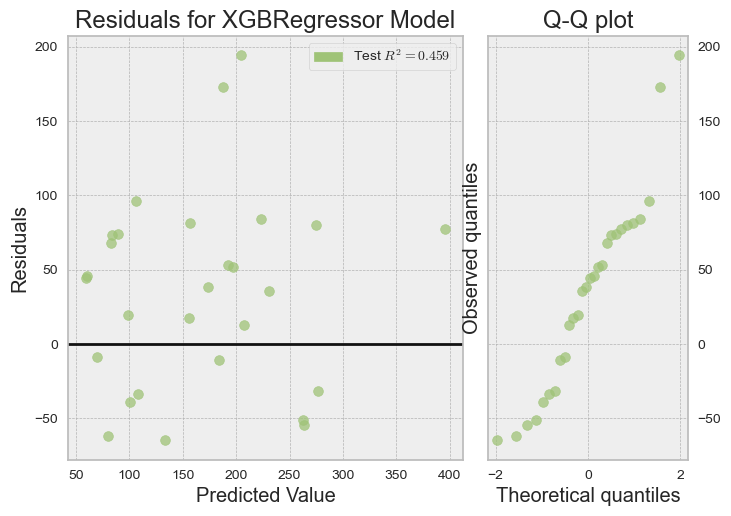

In [583]:
visualizer = ResidualsPlot(xgbr_top, hist=False, qqplot=True)
visualizer.score(xstest, ystest)
visualizer.show()
plt.show()